In [1]:
#%pip install opencv-python
%pip install tensorflow-datasets

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=0496925be041089d66f5fe1393897899b406af2d2fabf74dd4a23111dc5130aa
  Stored in directory: c:\users\kiehne\appdata\local\pip\cache\wheels\2f\a0\d3\4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=62392683ae3d598b962b2acd18af1a5a307663345f88dd92cf6aa337d34a5356
  Stored in directory: c:\users\kiehne\appdata\local\pip\cache\wheels\e1\e8\83\ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built future promise
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.13.0
    Uninstalling absl-py-0.13.0:
      Successfully uninstalled absl-py-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

def show_image_with_bbs(img, bbs):
    '''img and bbs should be numpy arrays
        bbs should have format [top, left, bottom, right]
        if bbs.dtype == "float32":
            we interprete bbs as relative bbs
        elif bbs.dtype is int32:
            we interprete them as absolute bbs
    '''
    if bbs.dtype == "float32":
        H, W = img.shape[:2]
        bbs[:, [1,3]] *= W
        bbs[:, [0,2]] *= H
        bbs = bbs.astype("int32")

    fig = plt.figure()
    ax = plt.gca()
    plt.imshow(img)
    for y1,x1,y2,x2 in bbs:
        rect = patches.Rectangle((min(x1,x2), min(y2,y1)), 
                                 abs(x2-x1), abs(y2-y1), 
                                 linewidth=1, edgecolor='r', 
                                 facecolor='none')
        ax.add_patch(rect)
    plt.show()

def tf_resize_img_with_bbs(img, bbs, H, W):
    '''
    Resizes the image and the bboxes with padding.
    img and bbs are expected to be Tensors.
    '''
    # compute the padding that will be added
    shape = tf.shape(img)
    h = shape[0]
    w = shape[1]
    scale = tf.cast(tf.minimum(H/h, W/w), "float32")
    nw = tf.cast(w, "float32") * scale
    nh = tf.cast(h, "float32") * scale

    # we divide by 2 to get the padding per side, not in total
    pad_x = (tf.cast(W, "float32") - nw)/2.0
    pad_y = (tf.cast(H, "float32") - nh)/2.0

    # resize the image
    img = tf.image.resize_with_pad(img, H, W)
    img = tf.cast(img, "uint8")

    # transform bboxes
    x_coords = (tf.gather(bbs, [1,3], axis=1)*nw + pad_x)/tf.cast(W, "float32")
    y_coords = (tf.gather(bbs, [0,2], axis=1)*nh + pad_y)/tf.cast(H, "float32")
    bbs = tf.stack([y_coords[:,0],x_coords[:,0],
                    y_coords[:,1],x_coords[:,1],], axis=1)
    return img, bbs

def tfds_resize_img_with_bbs(H, W):
    '''
    TF Dataset variant of `tf_resize_img_with_bbs`. Expects "image" and a "bbox" column
    '''
    def t(sample):
        img, bbs = tf_resize_img_with_bbs(sample["image"], sample["bbox"], H, W)
        return {"image":img, "bbox":bbs}
    return t

In [2]:
def tf_get_output_maps(bbs, H, W, stride):
    th, tw = H//stride, W//stride
    num_bbs = tf.shape(bbs)[0]
    cx = (bbs[:, 1] + bbs[:, 3])/2.0
    cy = (bbs[:, 0] + bbs[:, 2])/2.0
    indices = tf.cast(tf.floor(tf.stack([cy*th, cx*tw], axis=1)), "int32")
    values = tf.ones((num_bbs, 1))
    cmap = tf.scatter_nd(indices,values, [th,tw,1])

    # bb map
    # get absolute bb coords wrt to input dims
    abs_bbs = bbs * tf.cast([[H,W,H,W]],"float32")
    # we want for each cell in bb_map to contain the
    # offset of the bb in absolute pixels from the 
    # top left corner of the cell
    coords = tf.cast(tf.tile(indices, [1, 2]), "float32")
    # multiplying the cell indices by the network's stride
    # we get the coords of the top left corner in the input
    # image dims
    coords = coords * tf.cast([[stride,stride,stride,stride]],"float32")
    # by subtracting these coords, each bb is now expressed
    # relative to the coordinates of the cell it is contained in
    # this allows the network to learn position independent
    # representations
    rel_bbs = abs_bbs - coords
    bb_map = tf.scatter_nd(indices,rel_bbs,[th, tw, 4])
    return cmap, bb_map

def tfds_get_output_maps(H, W, stride):
    '''
    TF dataset variant of tf_get_output_maps.
    This function can be used to map a {.., "bbox":..}
    dataset to {"bbox":.., coverage":.., "bbox_map":..,...,}
    '''
    def f(sample):
        cmap, bbmap = tf_get_output_maps(sample["bbox"], H, W, stride)
        sample = sample.copy()
        sample.update({"coverage": cmap, "bbox_map": bbmap})
        return sample
    return f

def tf_bbs_from_output_maps(coverage, bbmap, H, W, stride, threshold = 0.5):
    '''
    Given coverage[th x tw x 1] and bbmap [th x tw x 4] tensors,
    computes the list of bounding boxes with a coverage>=threshold
    bbs in bbmap are expected to be relative to their cell
    positions.
    Returns bbs relative to image size, as usual.
    '''
    return_batched = True
    if coverage.ndim == 3:
        return_batched = False
        coverage = tf.expand_dims(coverage, 0)
        bbmap = tf.expand_dims(bbmap, 0)

    batch_size = tf.shape(bbmap)[0]
    bb_list = []

    for i in range(batch_size):
        # get the absolute offsets for the predicted cells
        indices = tf.where(coverage[i,:,:,0]>=threshold)
        bb_offsets = tf.gather_nd(bbmap[i], indices)
        # to reconstruct the bb according to the input image dimensions
        # we need to compute which coords in the input image correspond
        # to the cell in the output map (aka coverage, bbmap)
        # This is done simply by multiplying the indices by the stride
        # of the network
        indices = tf.cast(tf.tile(indices, [1, 2]),"float32")
        input_coords = indices * tf.cast([[stride,stride,stride,stride]],"float32")
        bbs = input_coords + bb_offsets
    
        bb_list.append(bbs)

    return bb_list if return_batched else bb_list[0]

def tfds_bbs_from_output_maps(H, W, stride, threshold=0.5):
    '''
    TF Dataset equivalent of `tf_bbs_from_output_maps`.
    Expects "coverage" and "bbox_map" columns to exist.
    
    '''
    def t(sample):
        bbs = tf_bbs_from_output_maps(sample["coverage"], sample["bbox_map"], H, W, stride, threshold)
        sample = sample.copy()
        sample.update({"bbox_pred": bbs})
        return sample
    return t

In [3]:
from tensorflow import keras

def masked_loss(loss):
    '''
    Returns the loss computed ONLY on the TRUE values of
    y_true!
    '''
    def l(y_true, y_pred):
        yp = tf.cast(y_true != 0., "float32") * y_pred
        return loss(y_true, yp)
    return l

class PlotCallback(keras.callbacks.Callback):
    def __init__(self, x, n=3, threshold=0.5, max_bbs=50):
        keras.callbacks.Callback.__init__(self)
        self.x = x
        self.n = n
        self.threshold = threshold
        self.max_bbs = max_bbs
        #self.y = y

    def on_epoch_end(self, *args):
        H,W = self.model.input_shape[1:3]
        th, tw = self.model.output_shape[0][1:3]
        stride = H//th
        cov, bbm = self.model.predict(self.x)
        bb_list = tf_bbs_from_output_maps(cov, bbm, H, W, stride, self.threshold)

        for i in range(self.n):
            fig, (left, right) = plt.subplots(1,2, squeeze=True)
            left.imshow(self.x[i])
            bbs = bb_list[i].numpy()[:self.max_bbs]
            #bbs *= [[H,W,H,W]]
            bbs = bbs.astype("int32")
            for y1,x1,y2,x2 in bbs:
                rect = patches.Rectangle((min(x1,x2), min(y2,y1)), 
                                         abs(x2-x1), abs(y2-y1), 
                                         linewidth=1, edgecolor='r', 
                                         facecolor='none')
                left.add_patch(rect)
            im = right.imshow(cov[i,:,:,0])
            fig.colorbar(im, ax=right)
            plt.show()

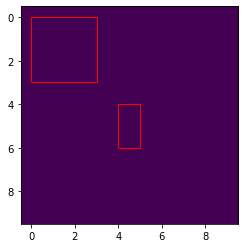

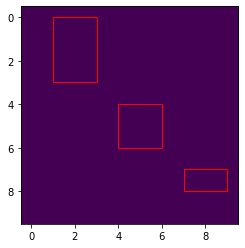

In [67]:
show_image_with_bbs(img[:,:,0], bbs_true.numpy())
show_image_with_bbs(img[:,:,0], bbs_pred.numpy())

In [4]:
def tf_iou(bbs_true, bbs_pred):
    '''
    Computes the pair-wise intersection-over-union metric
    for the given bounding box tensors.
    Both bbs_true and bbs_pred are expected to have shape
    [X,4], where X might be different.
    
    Returns a num_pred_bbs x num_true_bbs
    '''
    # assume bbs are sorted correctly
    n_true = tf.shape(bbs_true)[0]
    n_pred = tf.shape(bbs_pred)[0]
    # tiled true bbs
    bbtt = tf.tile(bbs_true[tf.newaxis],(n_pred,1,1))
    # tiled pred bbs
    bbpt = tf.tile(bbs_pred[:,tf.newaxis],(1,n_true,1))
    # get the highest top, left and the lowest right, bottom
    # components for each pair of true,pred bb
    # These components are the intersections between true and
    # pred pairs.
    intersections = tf.stack([
        tf.where(bbtt[:,:,0]>bbpt[:,:,0], bbtt[:,:,0], bbpt[:,:,0]),
        tf.where(bbtt[:,:,1]>bbpt[:,:,1], bbtt[:,:,1], bbpt[:,:,1]),
        tf.where(bbtt[:,:,2]<bbpt[:,:,2], bbtt[:,:,2], bbpt[:,:,2]),
        tf.where(bbtt[:,:,3]<bbpt[:,:,3], bbtt[:,:,3], bbpt[:,:,3])
    ],axis=-1)

    # filter out non-overlapping candidates
    index = tf.logical_and(intersections[:,:,0]<intersections[:,:,2],
                           intersections[:,:,1]<intersections[:,:,3])
    non_empty = intersections[index]
    # compute area of the intersections
    inter_area = (non_empty[:,2] - non_empty[:,0])*(non_empty[:,3] - non_empty[:,1])

    # get only those bbs that have an overlap
    bbtto = bbtt[index]
    bbpto = bbpt[index]
    # next we need the union of those pairs.
    # we compute the union as the sum of both areas minus the intersection area
    summed_area = (bbtto[:,2]-bbtto[:,0])*(bbtto[:,3]-bbtto[:,1]) + \
                    (bbpto[:,2]-bbpto[:,0])*(bbpto[:,3]-bbpto[:,1])

    union_area = summed_area - inter_area
    # these are the ious of only the overlapping pairs
    # we project them back into the n_pred x n_true matrix
    # using the index in the next step. Luckily, non-
    # overlapping bbs automatically have an iou of zero.
    ious = inter_area / union_area
    # project back into 2d matrix where non overlaps are zero.
    ious = tf.scatter_nd(tf.where(index), ious,(n_pred,n_true))
    return ious

In [8]:
H,W = 10,10
img = tf.zeros((H,W,1),"float32")
bbs_true = tf.convert_to_tensor([[0.,0.,0.3,0.3],])
bbs_pred = tf.convert_to_tensor([[0.,0.1,0.3,0.3],[.4,.4,0.6,0.6], [.7,0.7,0.8,0.9]])


print(tf_iou(bbs_true, bbs_pred))

tf.Tensor(
[[0.6666667]
 [0.       ]
 [0.       ]], shape=(3, 1), dtype=float32)


In [10]:
def tf_filter_bbs(bbs, min_h=0, max_h=1.0, min_w=0, max_w=1.0):
    '''
    Given a tensor of relative bbs, return those that lie
    within the given constraints.
    '''
    bbh = bbs[:,2] - bbs[:,0]
    bbw = bbs[:,3] - bbs[:,1]
    height_res = tf.logical_and(bbh>=min_h, bbh<=max_h)
    width_res = tf.logical_and(bbw>=min_w, bbw<=max_w)
    restrictions = tf.logical_and(height_res, width_res)
    bbs_new = tf.boolean_mask(bbs, restrictions)
    return bbs_new

def tfds_filter_bbs(min_h=0, max_h=1.0, min_w=0, max_w=1.0):
    def t(sample):
        bbs = tf_filter_bbs(sample["bbox"], min_h, max_h, min_w, max_w)
        sample = sample.copy()
        sample.update({"bbox": bbs})
        return sample
    return t    

def tfds_wider_pipeline(ds, H, W, stride, batch_size):
    ds = ds.map(lambda x: {"image":x["image"], "bbox": x["faces"]["bbox"]})
    #ds = ds.map(tfds_filter_bbs(0.1,0.3, 0.1,0.3))
    ds = ds.filter(lambda x: len(x["bbox"])>0 and len(x["bbox"])<20)
    ds = ds.map(tfds_resize_img_with_bbs(H, W))
    ds = ds.map(tfds_get_output_maps(H,W, stride))
    
    ds = ds.map(lambda x: (x["image"], (x["coverage"],x["bbox_map"])))
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

(ds_train, ds_test), ds_info = tfds.load(
    'wider_face',
    split=['train', 'validation'],
    shuffle_files=True,
    with_info=True,
)
H, W = 128, 256
stride = 8
batch_size = 16
th, tw = H//stride, W//stride
# setup training data pipeline
ds_train = tfds_wider_pipeline(ds_train, H, W, stride, batch_size)
ds_test = tfds_wider_pipeline(ds_test, H, W, stride, batch_size)

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D, GlobalMaxPool2D, SpatialDropout2D, Dense, BatchNormalization,
    Input, MaxPool2D, AvgPool2D
)

def bb_rectifier(x):
    neg = x[:,:,:,:2] * -1
    pos = x[:,:,:,2:]
    return tf.concat([neg, pos], axis=-1)

input_layer = Input((H,W,3), name="image")
l = input_layer
for i in range(3):
    for i in range(3):
        l = Conv2D(128, (3,3), activation="relu", padding="same")(l)
        l = BatchNormalization()(l)
        l = SpatialDropout2D(0.3)(l)

    l = AvgPool2D()(l)
l = Conv2D(64, (3,3), activation="relu", padding="same")(l)
bbox_layer = Conv2D(4, (3,3), activation="linear", padding="same", name="bbox")(l)
#bbox_layer = keras.layers.Lambda(bb_rectifier, name="bbox")(bbox_layer)
coverage_layer = Conv2D(1, (3,3), activation="sigmoid", padding="same", name="coverage")(l)
model = keras.models.Model(input_layer, [coverage_layer, bbox_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 128 3584        image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 128 512         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 128, 256, 128 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model = keras.models.load_model("data/1.2m-face-det.hdf5", compile=False)

Epoch 1/1000
      6/Unknown - 5s 299ms/step - loss: 1.9580 - coverage_loss: 1.3234 - bbox_loss: 0.6346 - coverage_true_positives_1: 333.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1159s vs `on_train_batch_end` time: 0.1850s). Check your callbacks.


701/701 [==============================] - 250s 352ms/step - loss: 0.3591 - coverage_loss: 0.1033 - bbox_loss: 0.2558 - coverage_true_positives_1: 1292.0000 - val_loss: 0.2322 - val_coverage_loss: 0.0484 - val_bbox_loss: 0.1837 - val_coverage_true_positives_1: 0.0000e+00


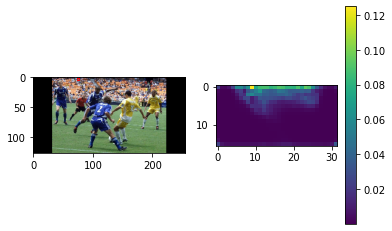

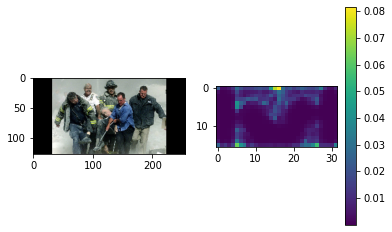

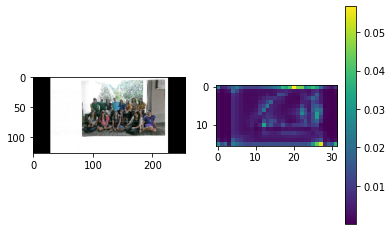

Epoch 2/1000
701/701 [==============================] - 229s 327ms/step - loss: 0.2281 - coverage_loss: 0.0453 - bbox_loss: 0.1827 - coverage_true_positives_1: 5.0000 - val_loss: 0.2065 - val_coverage_loss: 0.0398 - val_bbox_loss: 0.1667 - val_coverage_true_positives_1: 0.0000e+00


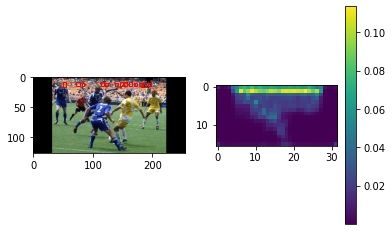

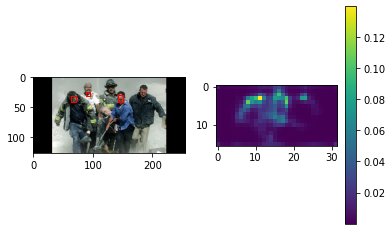

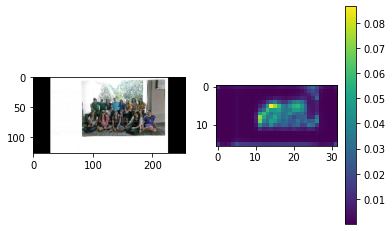

Epoch 3/1000
701/701 [==============================] - 228s 325ms/step - loss: 0.2067 - coverage_loss: 0.0408 - bbox_loss: 0.1659 - coverage_true_positives_1: 35.0000 - val_loss: 0.1852 - val_coverage_loss: 0.0366 - val_bbox_loss: 0.1486 - val_coverage_true_positives_1: 60.0000


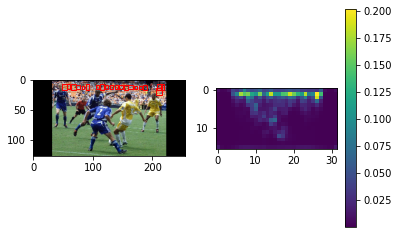

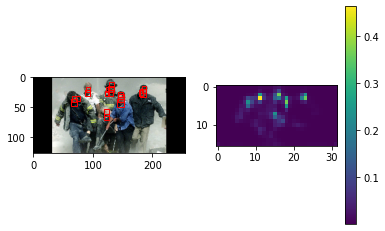

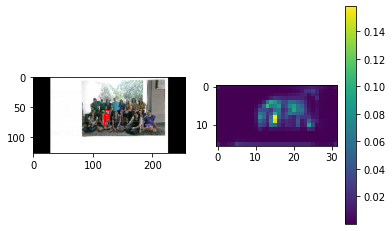

Epoch 4/1000
701/701 [==============================] - 227s 324ms/step - loss: 0.1898 - coverage_loss: 0.0376 - bbox_loss: 0.1522 - coverage_true_positives_1: 362.0000 - val_loss: 0.1664 - val_coverage_loss: 0.0339 - val_bbox_loss: 0.1325 - val_coverage_true_positives_1: 211.0000


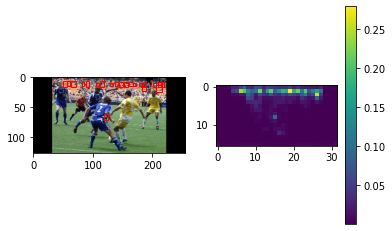

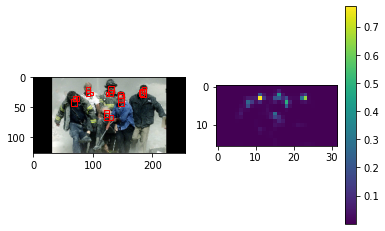

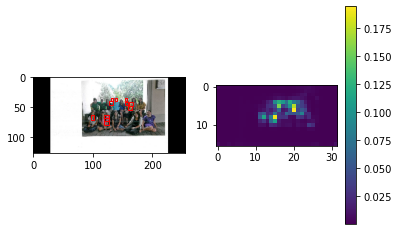

Epoch 5/1000
701/701 [==============================] - 229s 327ms/step - loss: 0.1784 - coverage_loss: 0.0356 - bbox_loss: 0.1429 - coverage_true_positives_1: 870.0000 - val_loss: 0.1679 - val_coverage_loss: 0.0318 - val_bbox_loss: 0.1361 - val_coverage_true_positives_1: 600.0000


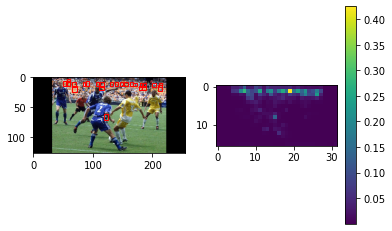

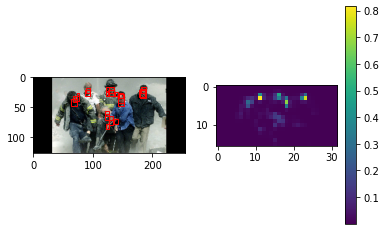

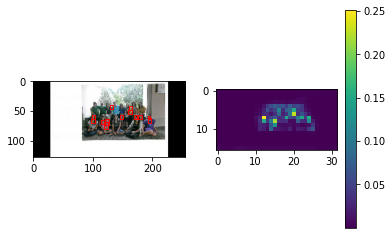

Epoch 6/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1671 - coverage_loss: 0.0337 - bbox_loss: 0.1334 - coverage_true_positives_1: 1764.0000 - val_loss: 0.1468 - val_coverage_loss: 0.0303 - val_bbox_loss: 0.1165 - val_coverage_true_positives_1: 928.0000


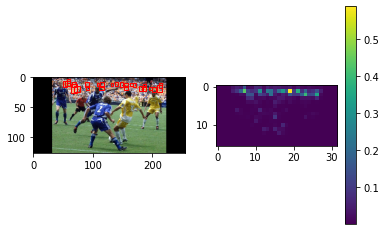

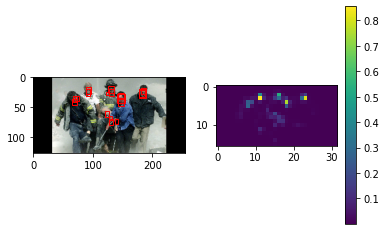

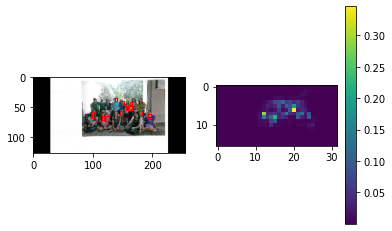

Epoch 7/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1598 - coverage_loss: 0.0324 - bbox_loss: 0.1275 - coverage_true_positives_1: 2477.0000 - val_loss: 0.1416 - val_coverage_loss: 0.0296 - val_bbox_loss: 0.1120 - val_coverage_true_positives_1: 1078.0000


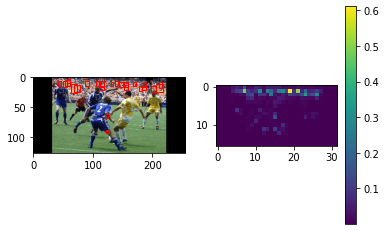

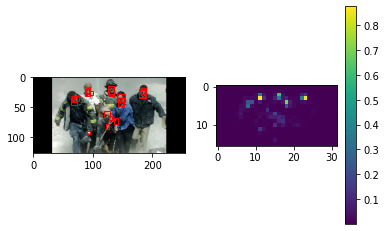

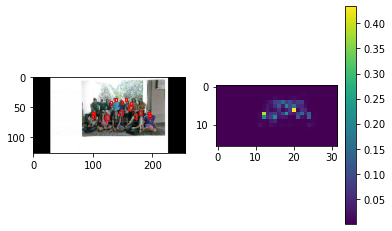

Epoch 8/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1529 - coverage_loss: 0.0314 - bbox_loss: 0.1215 - coverage_true_positives_1: 3384.0000 - val_loss: 0.1345 - val_coverage_loss: 0.0288 - val_bbox_loss: 0.1057 - val_coverage_true_positives_1: 1639.0000


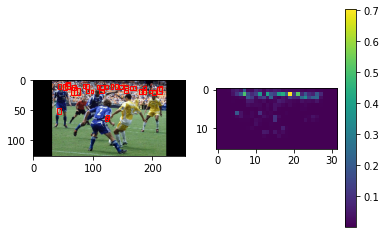

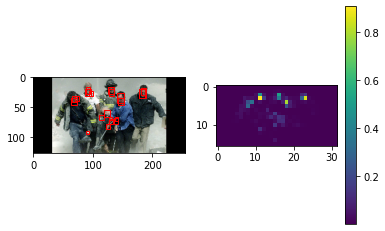

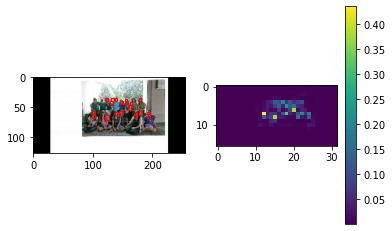

Epoch 9/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1483 - coverage_loss: 0.0306 - bbox_loss: 0.1177 - coverage_true_positives_1: 3779.0000 - val_loss: 0.1317 - val_coverage_loss: 0.0283 - val_bbox_loss: 0.1034 - val_coverage_true_positives_1: 2016.0000


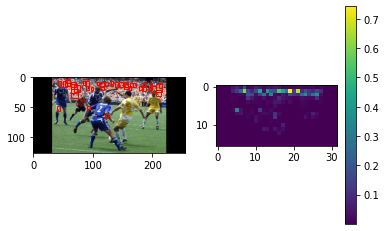

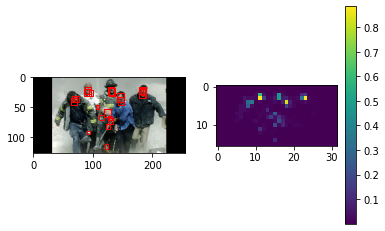

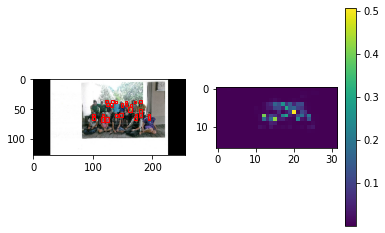

Epoch 10/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1433 - coverage_loss: 0.0298 - bbox_loss: 0.1135 - coverage_true_positives_1: 4702.0000 - val_loss: 0.1257 - val_coverage_loss: 0.0275 - val_bbox_loss: 0.0982 - val_coverage_true_positives_1: 2073.0000


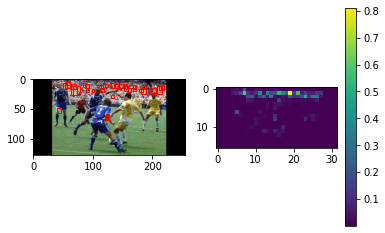

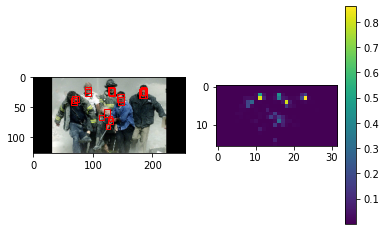

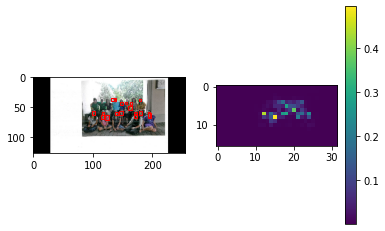

Epoch 11/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1363 - coverage_loss: 0.0291 - bbox_loss: 0.1072 - coverage_true_positives_1: 5294.0000 - val_loss: 0.1216 - val_coverage_loss: 0.0268 - val_bbox_loss: 0.0948 - val_coverage_true_positives_1: 2724.0000


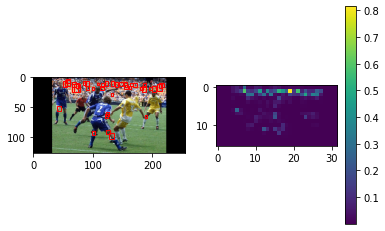

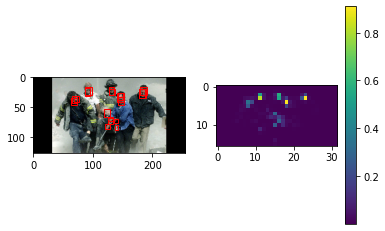

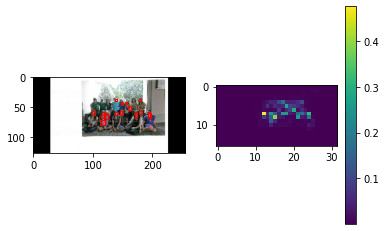

Epoch 12/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1327 - coverage_loss: 0.0287 - bbox_loss: 0.1040 - coverage_true_positives_1: 5822.0000 - val_loss: 0.1171 - val_coverage_loss: 0.0264 - val_bbox_loss: 0.0907 - val_coverage_true_positives_1: 2450.0000


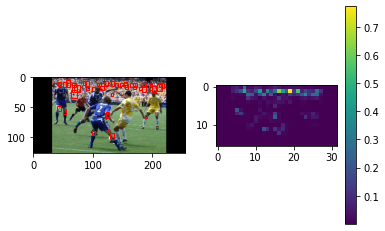

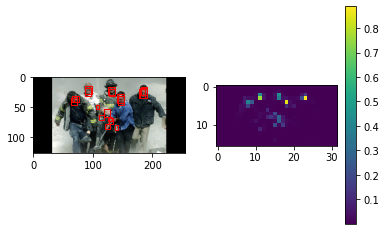

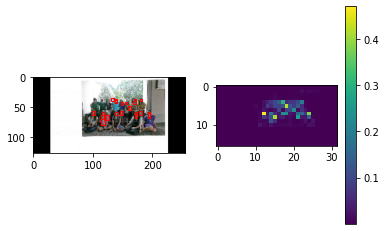

Epoch 13/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1303 - coverage_loss: 0.0279 - bbox_loss: 0.1024 - coverage_true_positives_1: 6426.0000 - val_loss: 0.1165 - val_coverage_loss: 0.0257 - val_bbox_loss: 0.0908 - val_coverage_true_positives_1: 2690.0000


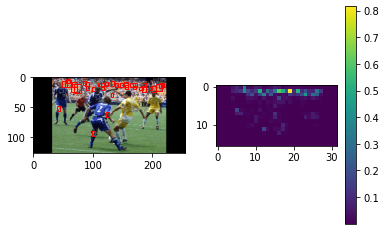

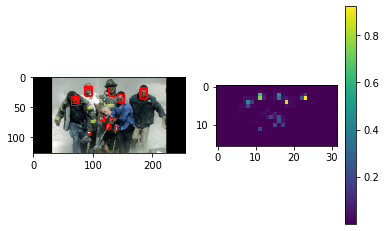

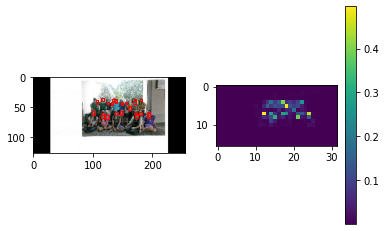

Epoch 14/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1247 - coverage_loss: 0.0274 - bbox_loss: 0.0973 - coverage_true_positives_1: 6929.0000 - val_loss: 0.1151 - val_coverage_loss: 0.0257 - val_bbox_loss: 0.0894 - val_coverage_true_positives_1: 3244.0000


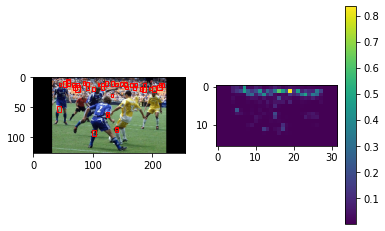

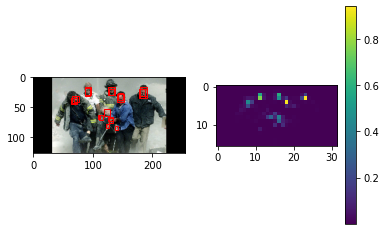

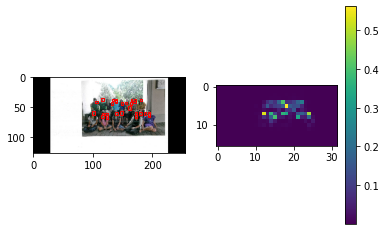

Epoch 15/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1229 - coverage_loss: 0.0271 - bbox_loss: 0.0958 - coverage_true_positives_1: 7408.0000 - val_loss: 0.1103 - val_coverage_loss: 0.0255 - val_bbox_loss: 0.0848 - val_coverage_true_positives_1: 3424.0000


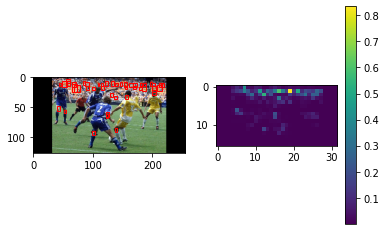

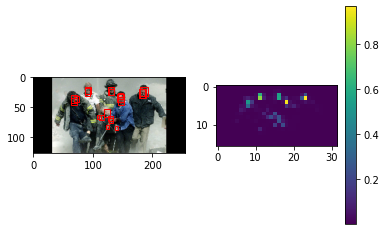

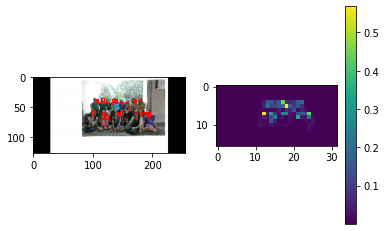

Epoch 16/1000
701/701 [==============================] - 227s 324ms/step - loss: 0.1190 - coverage_loss: 0.0267 - bbox_loss: 0.0922 - coverage_true_positives_1: 8065.0000 - val_loss: 0.1058 - val_coverage_loss: 0.0248 - val_bbox_loss: 0.0810 - val_coverage_true_positives_1: 3301.0000


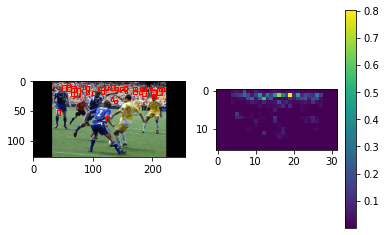

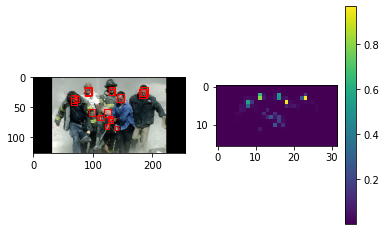

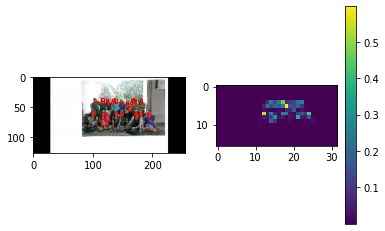

Epoch 17/1000
701/701 [==============================] - 225s 320ms/step - loss: 0.1174 - coverage_loss: 0.0264 - bbox_loss: 0.0910 - coverage_true_positives_1: 8432.0000 - val_loss: 0.1061 - val_coverage_loss: 0.0245 - val_bbox_loss: 0.0816 - val_coverage_true_positives_1: 3559.0000


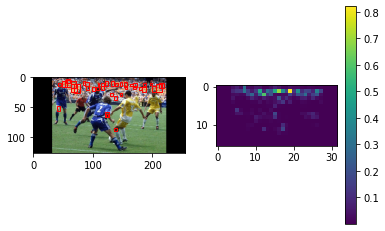

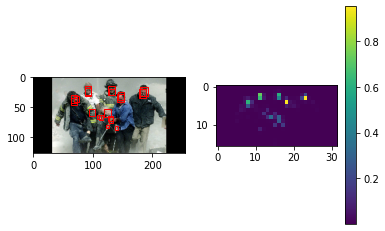

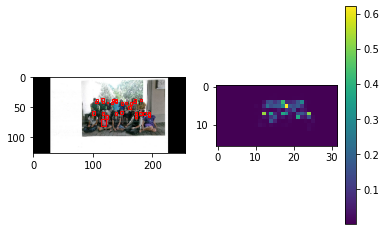

Epoch 18/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1133 - coverage_loss: 0.0259 - bbox_loss: 0.0875 - coverage_true_positives_1: 8770.0000 - val_loss: 0.1031 - val_coverage_loss: 0.0244 - val_bbox_loss: 0.0787 - val_coverage_true_positives_1: 3730.0000


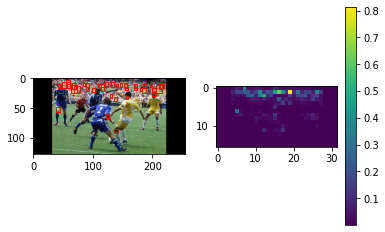

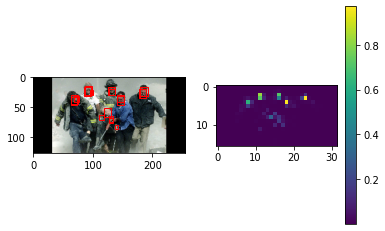

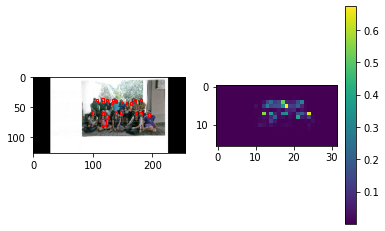

Epoch 19/1000
701/701 [==============================] - 226s 322ms/step - loss: 0.1132 - coverage_loss: 0.0258 - bbox_loss: 0.0874 - coverage_true_positives_1: 9335.0000 - val_loss: 0.1073 - val_coverage_loss: 0.0242 - val_bbox_loss: 0.0831 - val_coverage_true_positives_1: 3794.0000


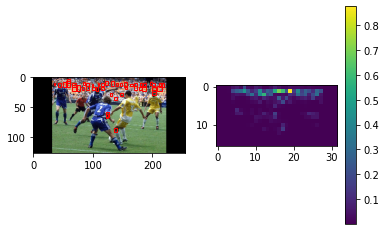

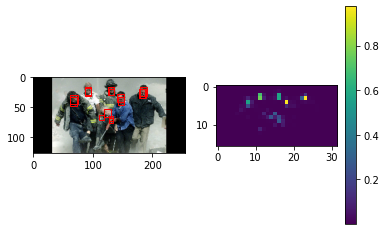

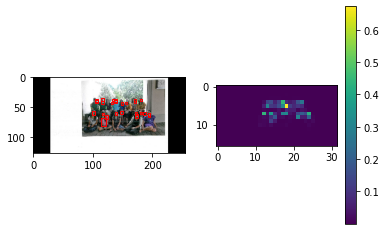

Epoch 20/1000
701/701 [==============================] - 223s 319ms/step - loss: 0.1118 - coverage_loss: 0.0253 - bbox_loss: 0.0864 - coverage_true_positives_1: 9521.0000 - val_loss: 0.1014 - val_coverage_loss: 0.0243 - val_bbox_loss: 0.0771 - val_coverage_true_positives_1: 4007.0000


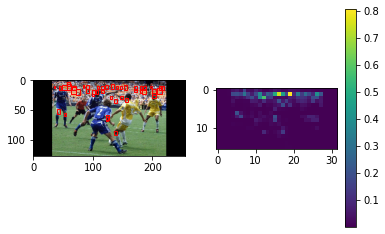

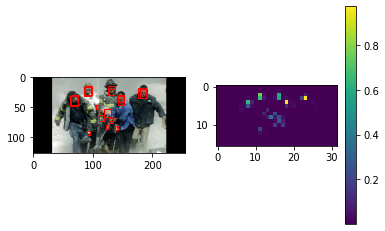

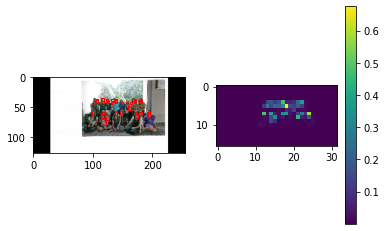

Epoch 21/1000
701/701 [==============================] - 226s 322ms/step - loss: 0.1078 - coverage_loss: 0.0250 - bbox_loss: 0.0828 - coverage_true_positives_1: 10042.0000 - val_loss: 0.1017 - val_coverage_loss: 0.0242 - val_bbox_loss: 0.0775 - val_coverage_true_positives_1: 4190.0000


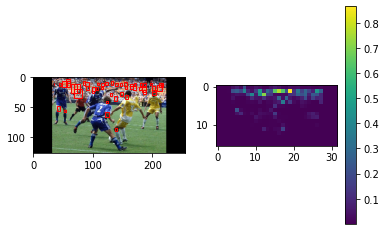

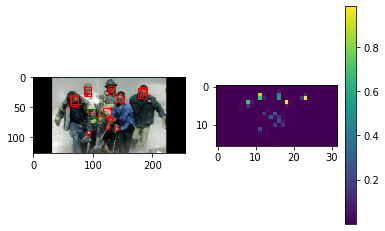

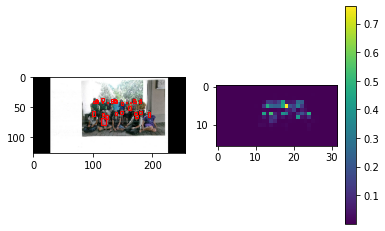

Epoch 22/1000
701/701 [==============================] - 226s 322ms/step - loss: 0.1078 - coverage_loss: 0.0250 - bbox_loss: 0.0828 - coverage_true_positives_1: 10162.0000 - val_loss: 0.0962 - val_coverage_loss: 0.0232 - val_bbox_loss: 0.0730 - val_coverage_true_positives_1: 3960.0000


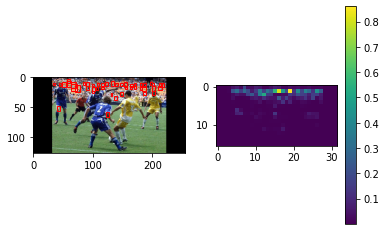

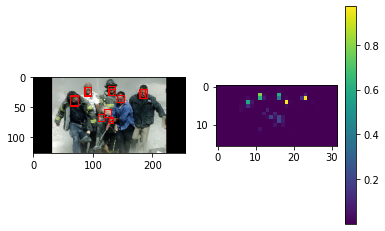

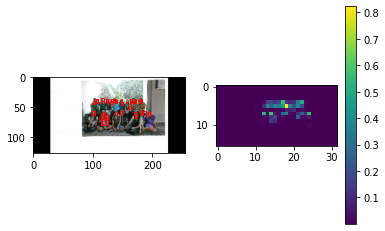

Epoch 23/1000
701/701 [==============================] - 225s 321ms/step - loss: 0.1064 - coverage_loss: 0.0246 - bbox_loss: 0.0817 - coverage_true_positives_1: 10448.0000 - val_loss: 0.0962 - val_coverage_loss: 0.0229 - val_bbox_loss: 0.0732 - val_coverage_true_positives_1: 4008.0000


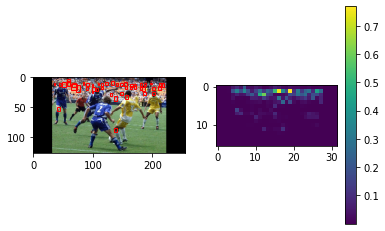

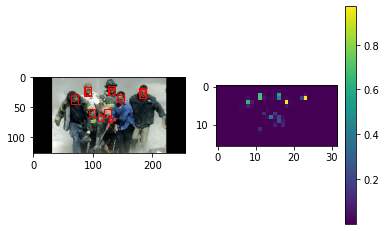

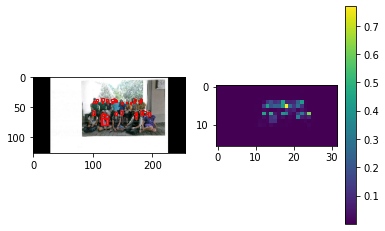

Epoch 24/1000
701/701 [==============================] - 226s 322ms/step - loss: 0.1033 - coverage_loss: 0.0243 - bbox_loss: 0.0790 - coverage_true_positives_1: 10926.0000 - val_loss: 0.0942 - val_coverage_loss: 0.0231 - val_bbox_loss: 0.0712 - val_coverage_true_positives_1: 4339.0000


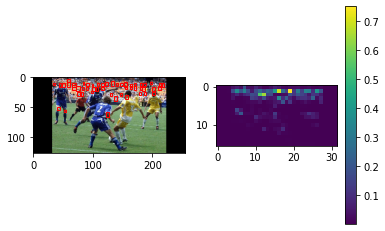

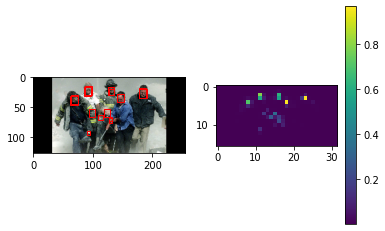

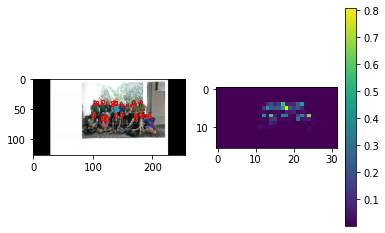

Epoch 25/1000
701/701 [==============================] - 226s 322ms/step - loss: 0.1010 - coverage_loss: 0.0240 - bbox_loss: 0.0770 - coverage_true_positives_1: 11382.0000 - val_loss: 0.0941 - val_coverage_loss: 0.0228 - val_bbox_loss: 0.0713 - val_coverage_true_positives_1: 4523.0000


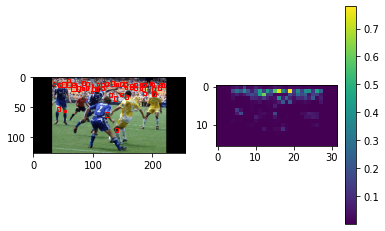

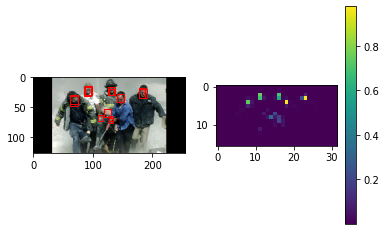

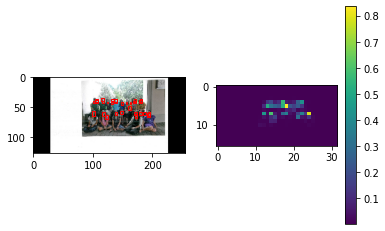

Epoch 26/1000
701/701 [==============================] - 225s 322ms/step - loss: 0.1006 - coverage_loss: 0.0239 - bbox_loss: 0.0767 - coverage_true_positives_1: 11493.0000 - val_loss: 0.0929 - val_coverage_loss: 0.0227 - val_bbox_loss: 0.0701 - val_coverage_true_positives_1: 4586.0000


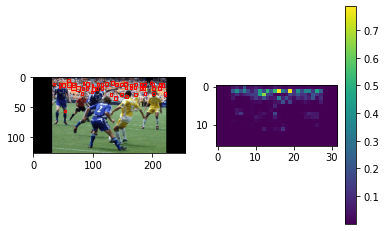

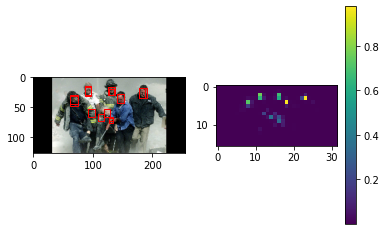

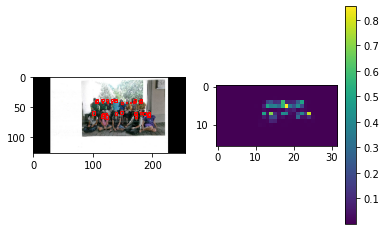

Epoch 27/1000
701/701 [==============================] - 218s 311ms/step - loss: 0.0998 - coverage_loss: 0.0237 - bbox_loss: 0.0761 - coverage_true_positives_1: 11719.0000 - val_loss: 0.0900 - val_coverage_loss: 0.0221 - val_bbox_loss: 0.0679 - val_coverage_true_positives_1: 4531.0000


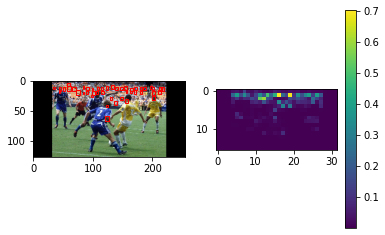

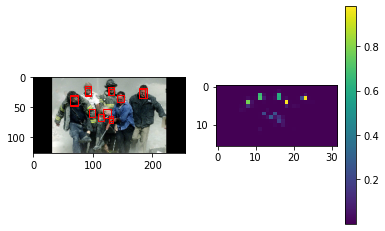

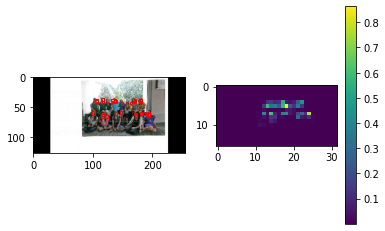

Epoch 28/1000
701/701 [==============================] - 208s 296ms/step - loss: 0.0974 - coverage_loss: 0.0236 - bbox_loss: 0.0738 - coverage_true_positives_1: 11911.0000 - val_loss: 0.0903 - val_coverage_loss: 0.0223 - val_bbox_loss: 0.0680 - val_coverage_true_positives_1: 4501.0000


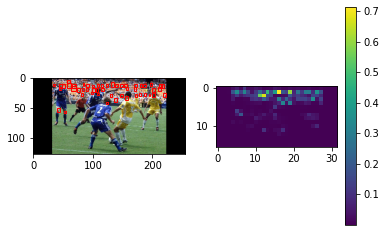

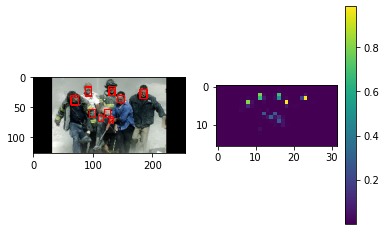

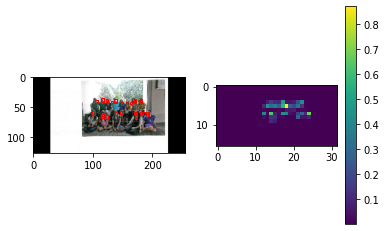

Epoch 29/1000
701/701 [==============================] - 210s 299ms/step - loss: 0.0955 - coverage_loss: 0.0234 - bbox_loss: 0.0721 - coverage_true_positives_1: 12082.0000 - val_loss: 0.0895 - val_coverage_loss: 0.0218 - val_bbox_loss: 0.0677 - val_coverage_true_positives_1: 4633.0000


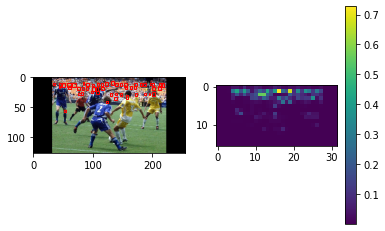

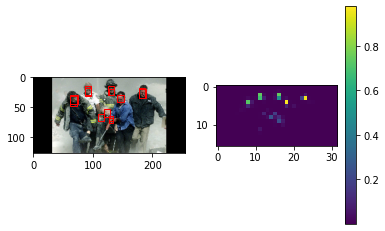

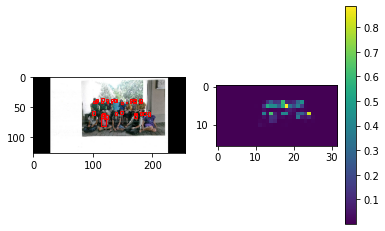

Epoch 30/1000
701/701 [==============================] - 209s 298ms/step - loss: 0.0961 - coverage_loss: 0.0231 - bbox_loss: 0.0730 - coverage_true_positives_1: 12413.0000 - val_loss: 0.0924 - val_coverage_loss: 0.0222 - val_bbox_loss: 0.0702 - val_coverage_true_positives_1: 4569.0000


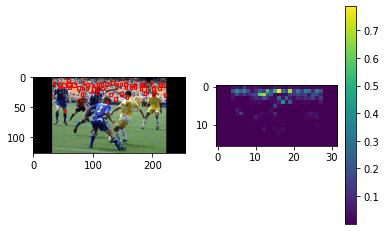

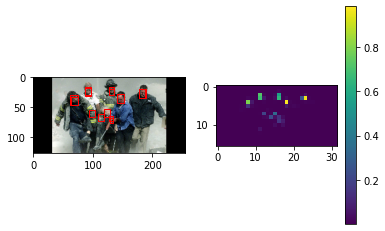

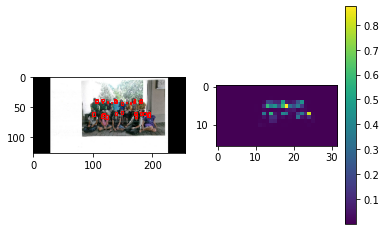

Epoch 31/1000
701/701 [==============================] - 210s 300ms/step - loss: 0.0949 - coverage_loss: 0.0231 - bbox_loss: 0.0718 - coverage_true_positives_1: 12451.0000 - val_loss: 0.0903 - val_coverage_loss: 0.0218 - val_bbox_loss: 0.0684 - val_coverage_true_positives_1: 4711.0000


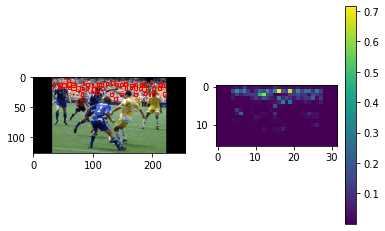

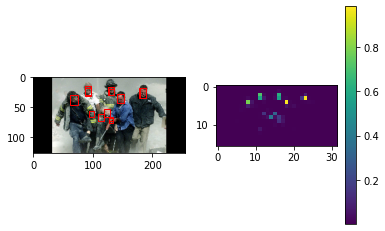

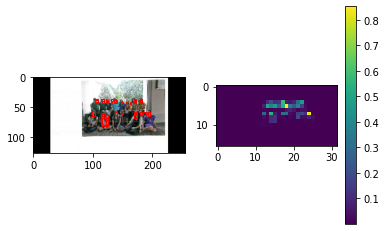

Epoch 32/1000
701/701 [==============================] - 215s 307ms/step - loss: 0.0931 - coverage_loss: 0.0231 - bbox_loss: 0.0700 - coverage_true_positives_1: 12635.0000 - val_loss: 0.0879 - val_coverage_loss: 0.0221 - val_bbox_loss: 0.0658 - val_coverage_true_positives_1: 4878.0000


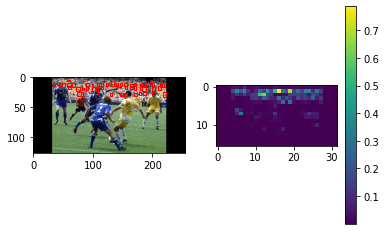

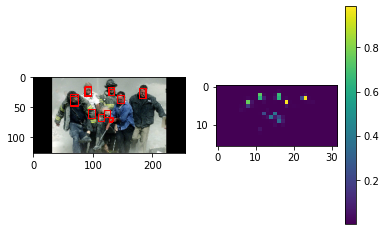

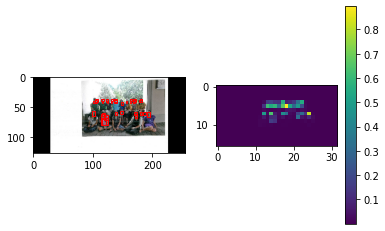

Epoch 33/1000
701/701 [==============================] - 223s 318ms/step - loss: 0.0915 - coverage_loss: 0.0229 - bbox_loss: 0.0686 - coverage_true_positives_1: 12690.0000 - val_loss: 0.0843 - val_coverage_loss: 0.0216 - val_bbox_loss: 0.0627 - val_coverage_true_positives_1: 5016.0000


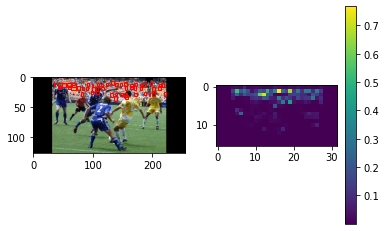

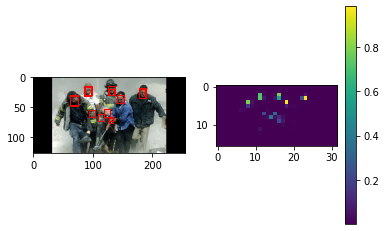

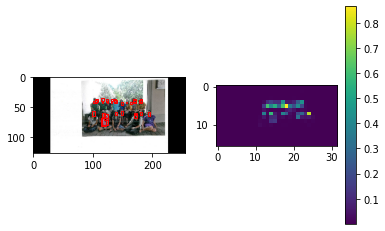

Epoch 34/1000
701/701 [==============================] - 222s 317ms/step - loss: 0.0912 - coverage_loss: 0.0227 - bbox_loss: 0.0685 - coverage_true_positives_1: 13010.0000 - val_loss: 0.0847 - val_coverage_loss: 0.0216 - val_bbox_loss: 0.0631 - val_coverage_true_positives_1: 4769.0000


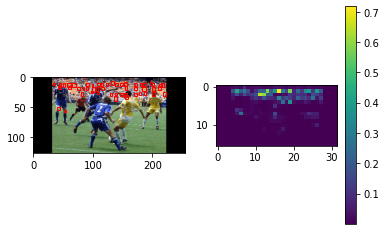

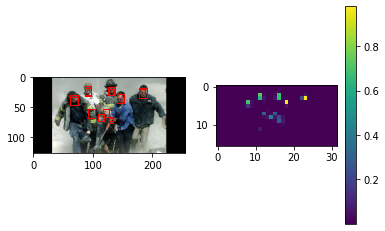

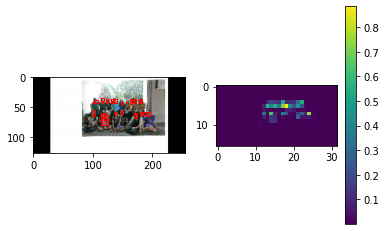

Epoch 35/1000
701/701 [==============================] - 222s 316ms/step - loss: 0.0893 - coverage_loss: 0.0226 - bbox_loss: 0.0667 - coverage_true_positives_1: 13181.0000 - val_loss: 0.0884 - val_coverage_loss: 0.0216 - val_bbox_loss: 0.0667 - val_coverage_true_positives_1: 4962.0000


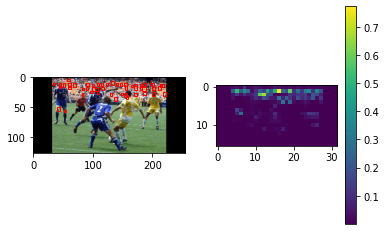

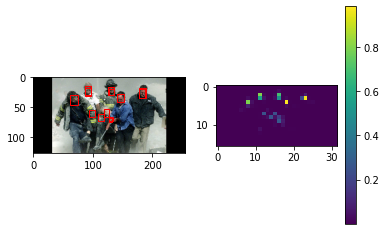

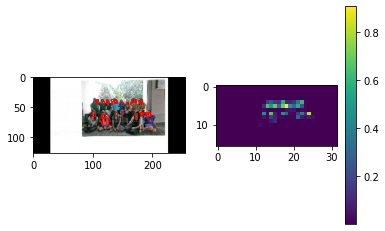

Epoch 36/1000
701/701 [==============================] - 222s 317ms/step - loss: 0.0886 - coverage_loss: 0.0224 - bbox_loss: 0.0662 - coverage_true_positives_1: 13342.0000 - val_loss: 0.0839 - val_coverage_loss: 0.0216 - val_bbox_loss: 0.0623 - val_coverage_true_positives_1: 5159.0000


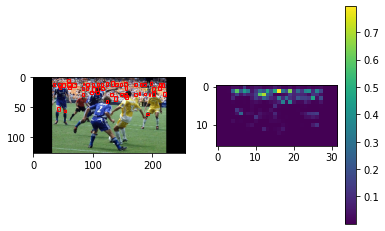

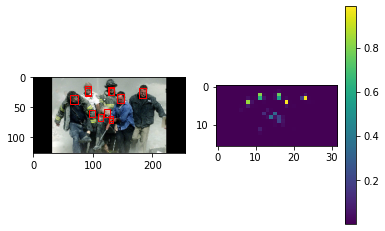

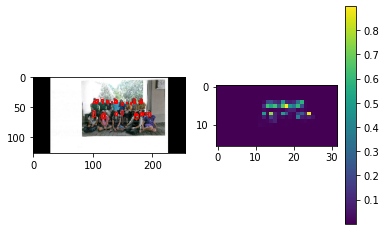

Epoch 37/1000
701/701 [==============================] - 222s 317ms/step - loss: 0.0884 - coverage_loss: 0.0224 - bbox_loss: 0.0660 - coverage_true_positives_1: 13417.0000 - val_loss: 0.0911 - val_coverage_loss: 0.0219 - val_bbox_loss: 0.0692 - val_coverage_true_positives_1: 5046.0000


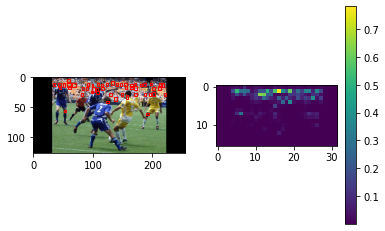

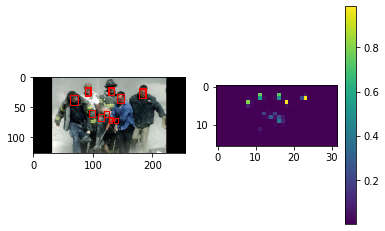

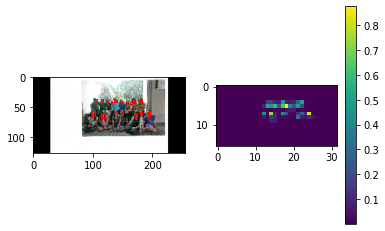

Epoch 38/1000
701/701 [==============================] - 222s 316ms/step - loss: 0.0872 - coverage_loss: 0.0223 - bbox_loss: 0.0649 - coverage_true_positives_1: 13488.0000 - val_loss: 0.0840 - val_coverage_loss: 0.0212 - val_bbox_loss: 0.0628 - val_coverage_true_positives_1: 4967.0000


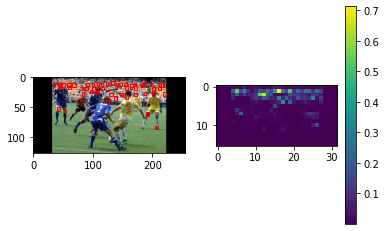

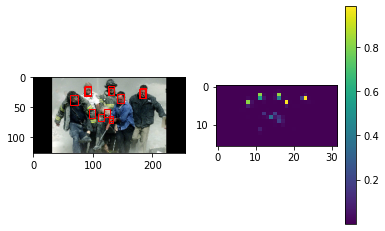

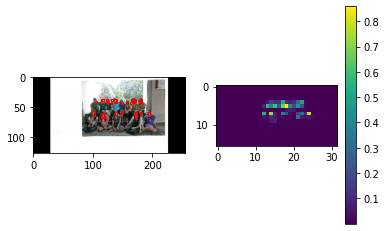

Epoch 39/1000
701/701 [==============================] - 223s 318ms/step - loss: 0.0859 - coverage_loss: 0.0221 - bbox_loss: 0.0638 - coverage_true_positives_1: 13740.0000 - val_loss: 0.0817 - val_coverage_loss: 0.0210 - val_bbox_loss: 0.0607 - val_coverage_true_positives_1: 5036.0000


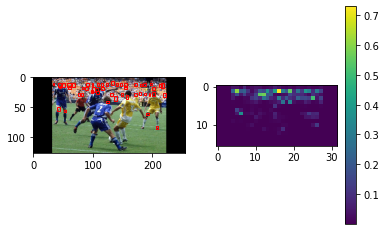

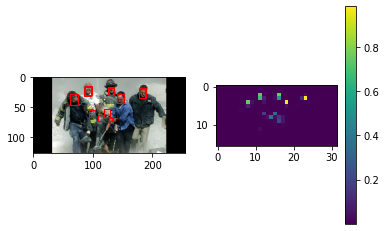

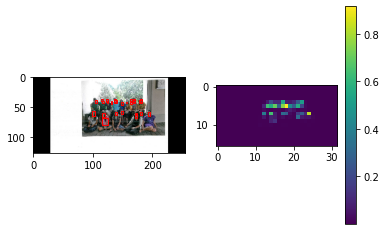

Epoch 40/1000
701/701 [==============================] - 222s 317ms/step - loss: 0.0843 - coverage_loss: 0.0220 - bbox_loss: 0.0623 - coverage_true_positives_1: 14022.0000 - val_loss: 0.0843 - val_coverage_loss: 0.0213 - val_bbox_loss: 0.0630 - val_coverage_true_positives_1: 5109.0000


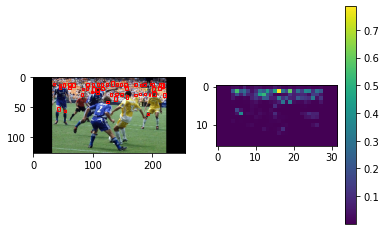

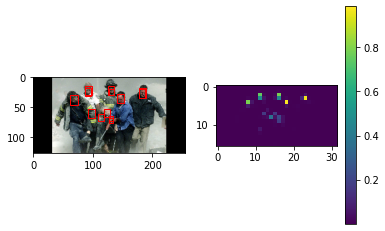

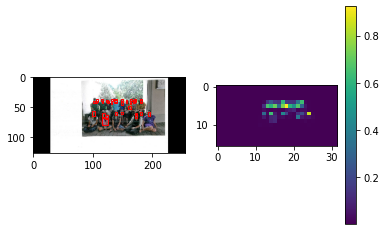

Epoch 41/1000
701/701 [==============================] - 241s 344ms/step - loss: 0.0835 - coverage_loss: 0.0219 - bbox_loss: 0.0616 - coverage_true_positives_1: 14103.0000 - val_loss: 0.0820 - val_coverage_loss: 0.0207 - val_bbox_loss: 0.0613 - val_coverage_true_positives_1: 5080.0000


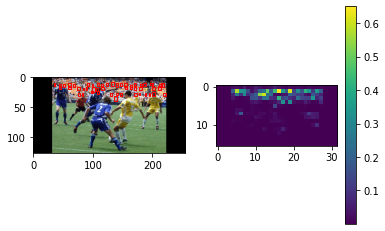

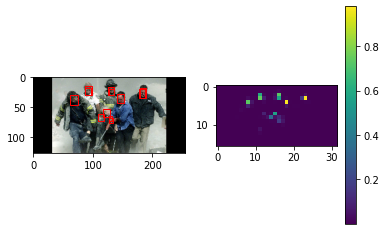

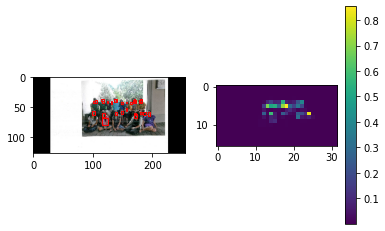

Epoch 42/1000
701/701 [==============================] - 238s 339ms/step - loss: 0.0840 - coverage_loss: 0.0218 - bbox_loss: 0.0622 - coverage_true_positives_1: 14119.0000 - val_loss: 0.0825 - val_coverage_loss: 0.0210 - val_bbox_loss: 0.0615 - val_coverage_true_positives_1: 5318.0000


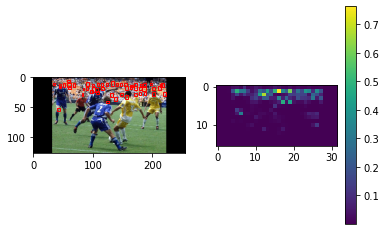

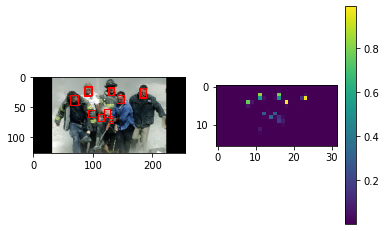

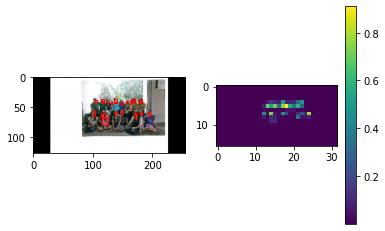

Epoch 43/1000
701/701 [==============================] - 229s 327ms/step - loss: 0.0839 - coverage_loss: 0.0217 - bbox_loss: 0.0622 - coverage_true_positives_1: 14328.0000 - val_loss: 0.0796 - val_coverage_loss: 0.0203 - val_bbox_loss: 0.0593 - val_coverage_true_positives_1: 4986.0000


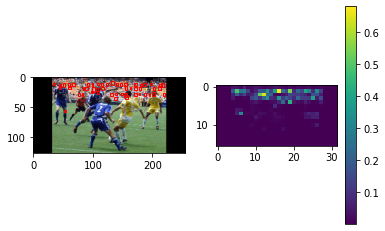

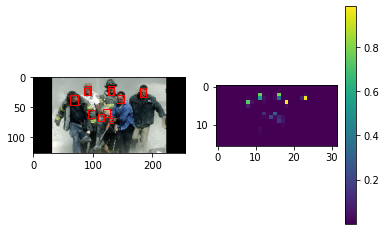

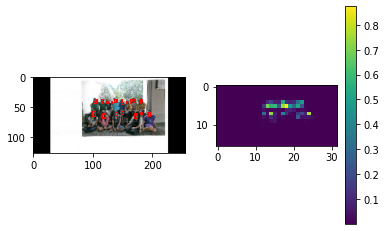

Epoch 44/1000
701/701 [==============================] - 228s 326ms/step - loss: 0.0820 - coverage_loss: 0.0215 - bbox_loss: 0.0605 - coverage_true_positives_1: 14507.0000 - val_loss: 0.0812 - val_coverage_loss: 0.0206 - val_bbox_loss: 0.0605 - val_coverage_true_positives_1: 5093.0000


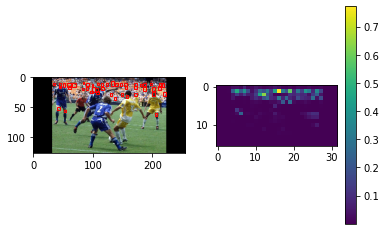

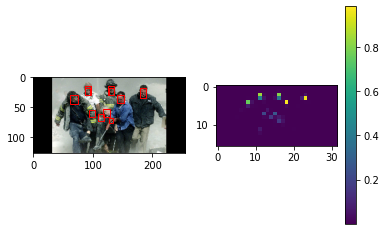

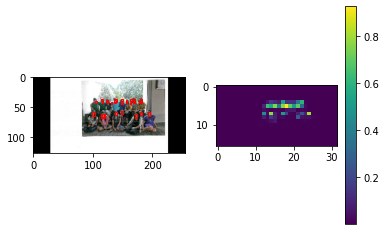

Epoch 45/1000
701/701 [==============================] - 229s 326ms/step - loss: 0.0824 - coverage_loss: 0.0216 - bbox_loss: 0.0608 - coverage_true_positives_1: 14518.0000 - val_loss: 0.0810 - val_coverage_loss: 0.0208 - val_bbox_loss: 0.0601 - val_coverage_true_positives_1: 5333.0000


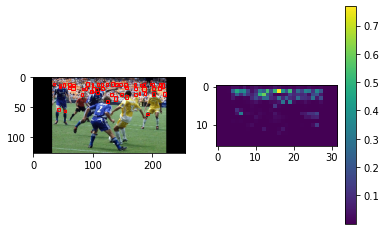

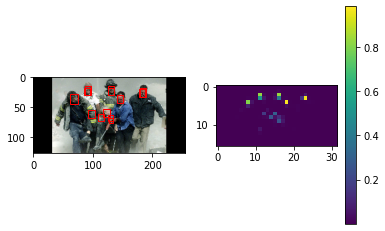

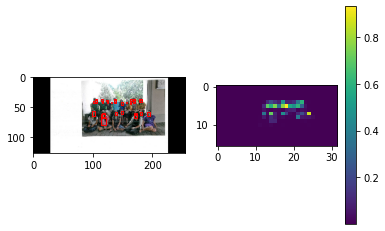

Epoch 46/1000
701/701 [==============================] - 220s 314ms/step - loss: 0.0807 - coverage_loss: 0.0215 - bbox_loss: 0.0592 - coverage_true_positives_1: 14477.0000 - val_loss: 0.0784 - val_coverage_loss: 0.0205 - val_bbox_loss: 0.0579 - val_coverage_true_positives_1: 5314.0000


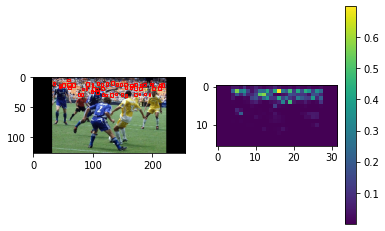

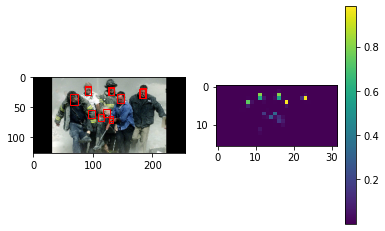

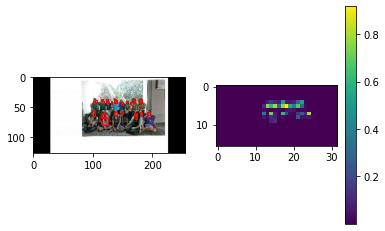

Epoch 47/1000
701/701 [==============================] - 229s 326ms/step - loss: 0.0799 - coverage_loss: 0.0213 - bbox_loss: 0.0586 - coverage_true_positives_1: 14816.0000 - val_loss: 0.0791 - val_coverage_loss: 0.0207 - val_bbox_loss: 0.0584 - val_coverage_true_positives_1: 5386.0000


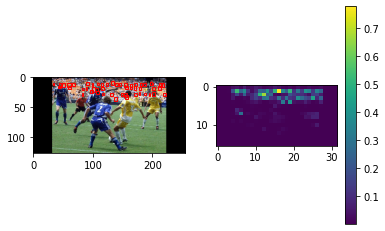

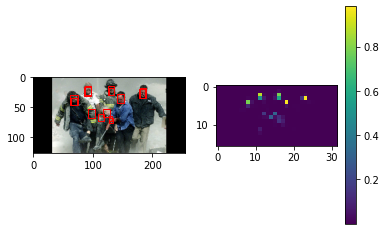

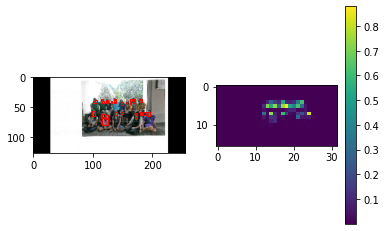

Epoch 48/1000
701/701 [==============================] - 228s 325ms/step - loss: 0.0801 - coverage_loss: 0.0213 - bbox_loss: 0.0588 - coverage_true_positives_1: 14798.0000 - val_loss: 0.0789 - val_coverage_loss: 0.0206 - val_bbox_loss: 0.0583 - val_coverage_true_positives_1: 5403.0000


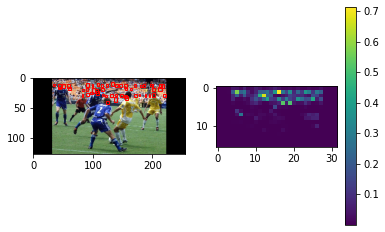

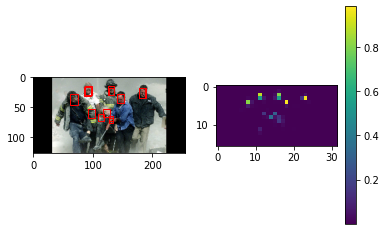

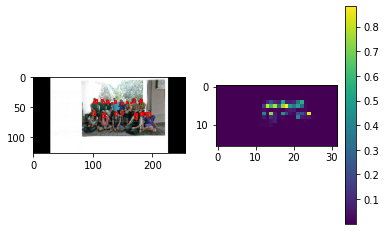

Epoch 49/1000
701/701 [==============================] - 219s 312ms/step - loss: 0.0790 - coverage_loss: 0.0213 - bbox_loss: 0.0577 - coverage_true_positives_1: 14868.0000 - val_loss: 0.0790 - val_coverage_loss: 0.0200 - val_bbox_loss: 0.0590 - val_coverage_true_positives_1: 5165.0000


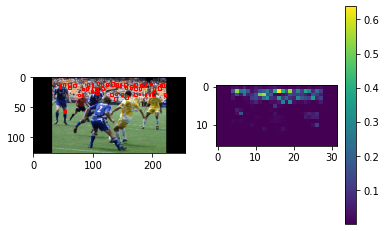

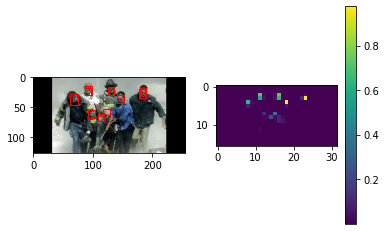

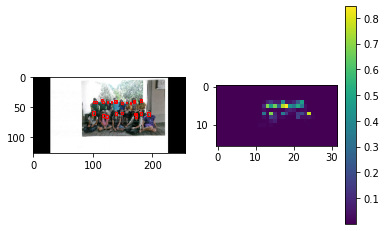

Epoch 50/1000
701/701 [==============================] - 217s 310ms/step - loss: 0.0792 - coverage_loss: 0.0211 - bbox_loss: 0.0581 - coverage_true_positives_1: 15101.0000 - val_loss: 0.0824 - val_coverage_loss: 0.0208 - val_bbox_loss: 0.0616 - val_coverage_true_positives_1: 5252.0000


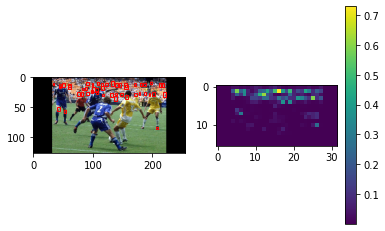

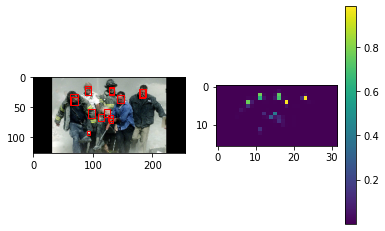

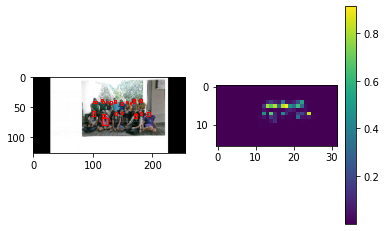

Epoch 51/1000
701/701 [==============================] - 218s 311ms/step - loss: 0.0793 - coverage_loss: 0.0212 - bbox_loss: 0.0581 - coverage_true_positives_1: 15017.0000 - val_loss: 0.0792 - val_coverage_loss: 0.0203 - val_bbox_loss: 0.0589 - val_coverage_true_positives_1: 5431.0000


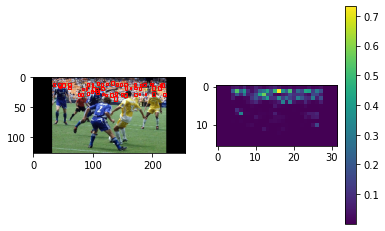

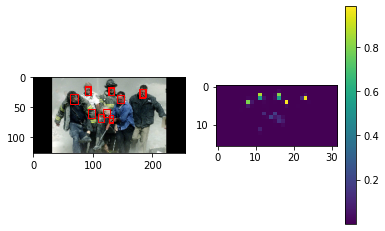

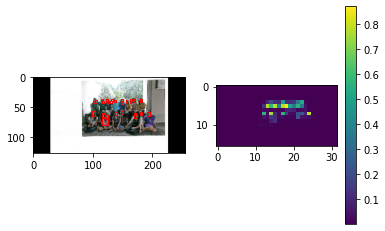

Epoch 52/1000
126/701 [====>.........................] - ETA: 2:47 - loss: 0.0766 - coverage_loss: 0.0203 - bbox_loss: 0.0563 - coverage_true_positives_1: 2563.0000

KeyboardInterrupt: 

In [186]:
class Accuracy2D(keras.metrics.BinaryAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        batch_size = tf.shape(y_true)[0]
        y_true = tf.reshape(y_true, (batch_size, -1))
        y_pred = tf.reshape(y_pred, (batch_size, -1))

        return super(keras.metrics.BinaryAccuracy, self).update_state(y_true, y_pred, sample_weight)

# make some plot samples
ds = ds_train.take(2)
#ds = ds_test.take(1)
x, (cov, bbm) = next(ds.as_numpy_iterator())
cb = [
    PlotCallback(x, n=3, threshold=0.1),
]
loss = {
    "coverage": "binary_crossentropy",
    "bbox": masked_loss(keras.losses.MSE),
}
loss_weights = {
    "coverage": 1.0,
    "bbox": 1.0
}
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(opt, loss, {"coverage":keras.metrics.TruePositives()}, 
              loss_weights=loss_weights)
model.fit(ds_train, epochs=1000, verbose=1, callbacks=cb,
         validation_data=ds_test)

tf.Tensor([[ 43.77565  120.29549   59.184677 141.658   ]], shape=(1, 4), dtype=float32)


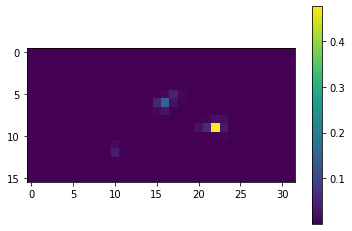

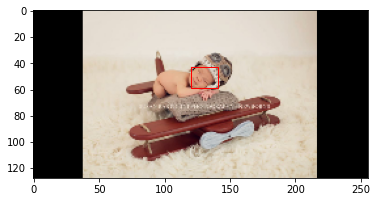

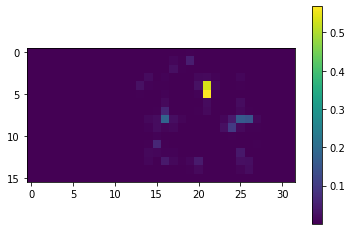

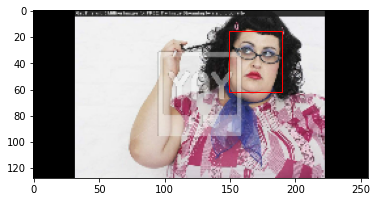

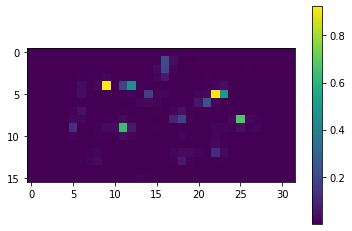

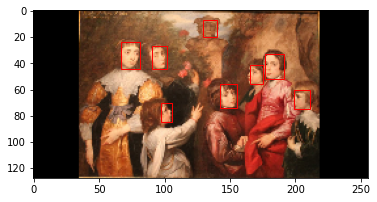

In [187]:
ds = ds_test.take(1)
x, (cov, bbm) = next(ds.as_numpy_iterator())
(cov_pred, bbm_pred) = model.predict(x)


bbs = tf_bbs_from_output_maps(cov, bbm, H, W, stride, 0.05)
print(bbs[0])
for i in range(3):
    plt.imshow(cov_pred[i,:,:,0])
    plt.colorbar()
    show_image_with_bbs(x[i], (bbs[i].numpy())[:10].astype("int32"))


In [189]:
x,y = np.where(cov[0,:,:,0])
print(bbm[0,x[0],y[0]])
print(bbm_pred[0,x[0],y[0]])

[-4.22435   -7.7045135 11.184677  13.658005 ]
[-8.159705  -7.2212033 15.57122   13.421173 ]


In [190]:
model.save("data/1.2m-face-det.hdf5")